In [1]:
%matplotlib inline
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pydub

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3MB 25kB/s 
     |████████████████████████████████| 12.7MB 267kB/s 
     |████████████████████████████████| 7.6MB 7.6MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
print(torch.cuda.is_available())

True


In [3]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

In [6]:
#Define a class subset derived from SpeechCommands
class SubsetSC(SPEECHCOMMANDS):
      def __init__(self, subset: str = None):
          super().__init__("./", download=True)

        # member function to load list of a particular split
          def load_list(filename):
              filepath = os.path.join(self._path, filename)
              with open(filepath) as fileobj:
                  return [os.path.join(self._path, line.strip()) for line in fileobj]

          if subset == "validation":
              self._walker = load_list("validation_list.txt")
          elif subset == "testing":
              self._walker = load_list("testing_list.txt")
          elif subset == "training":
              excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
              excludes = set(excludes)
              self._walker = [w for w in self._walker if w not in excludes]


train_set = SubsetSC("training")
test_set = SubsetSC("testing")


In [7]:
print(len(train_set))
print(len(test_set))
print(train_set[0])
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]


84843
11005
(tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]]), 16000, 'backward', '0165e0e8', 0)


Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


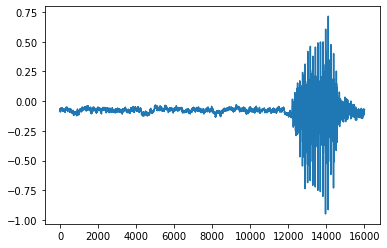

In [8]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
plt.plot(waveform.t().numpy());

In [9]:
labels = {datapoint[2] for datapoint in train_set}
labels

{'backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero'}

In [10]:
rand_id=np.random.randint(len(train_set))
print(rand_id)
print(train_set[rand_id][2])
waveform_first, *_ = train_set[rand_id]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

77132
wow


In [11]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform_first)
ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [12]:
labels=sorted(list(labels))

In [13]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = labels[np.random.randint(len(labels))]
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

house --> tensor(13) --> house


In [14]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [transform(waveform)]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

In [15]:
device="cuda"
batch_size = 256
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [16]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
      # define what each layer looks like
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
      #What is out information flow through each of the layer
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
      # our final output is a softmax over the ouput layer which represents the probability of our input being from each class.
        return F.log_softmax(x, dim=2)

In [17]:
model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [19]:
def train(model, epoch, log_interval):
  # It is important to set the model to train mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

      # import to set gradients to zero to flush out old values
        optimizer.zero_grad()

      # calculate gradients based on present loss value
        loss.backward()

      #change weights based on optimiser
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [20]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
  # Important to set the model to eval mode. Without this some layers like batchnorm, dropout etc won't work well
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.793589
Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.249799
Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.811136
Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.412363
Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.044471
Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.957205
Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.748867
Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.669101
Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.683970
Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.571072
Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.514221
Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.407776
Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.191331
Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.246703
Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.340715
Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.025108
Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.045156

Test Epoch: 1	Accuracy: 7117/11005 (65%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.004298
Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.999938
Train Epoch: 2 [10240

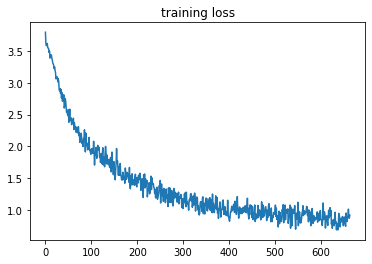

In [22]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

In [64]:
def predict(tensor):
      # Use the model to predict the label of the waveform
      tensor = tensor.to(device)
      tensor = transform(tensor)
      tensor = model(tensor.unsqueeze(0))
      tensor = get_likely_index(tensor)
      tensor = index_to_label(tensor.squeeze())
      return tensor

waveform, sample_rate, utterance, *_ = train_set[np.random.randint(len(train_set))]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: wow. Predicted: wow.


In [62]:
from google.colab import output as colab_output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment


RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""


def record(seconds=1):
    display(ipd.Javascript(RECORD))
    print(f"Recording started for {seconds} seconds.")
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


waveform, sample_rate = record()
print(f"Predicted: {predict(waveform)}.")
ipd.Audio(waveform.numpy(), rate=sample_rate)

<IPython.core.display.Javascript object>

Recording started for 1 seconds.
Recording ended.
Predicted: two.
